# Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 8*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-08-24 13:10:46.391458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:10:46.491704: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 13:10:46.875139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-24 13:10:46.875192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-24 13:10:47.525800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:10:47.526580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:47.526817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:47.526966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #was this -- having trouble not forming voxels on surfaces very close to sensor
# show_nth = 3 #test using more points from HD Map
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

# submap = submap[submap[:,2]> -0.9]#remove ground plane (for scan to submap in experiment 1)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [6]:
# idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
# # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

# pc1 = np.load(fn1)

# #load ground truth
# # [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# # fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
# gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# # print(gt[idx, 2:])

# offset = 0#for debug 
# rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# # rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# # rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# # print(rot_m)

# initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# # pc1 = pc1 @ rot_m
# # rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# # pc1 = pc1 @ rotcorr
# # pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [10]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

<IPython.core.display.Javascript object>


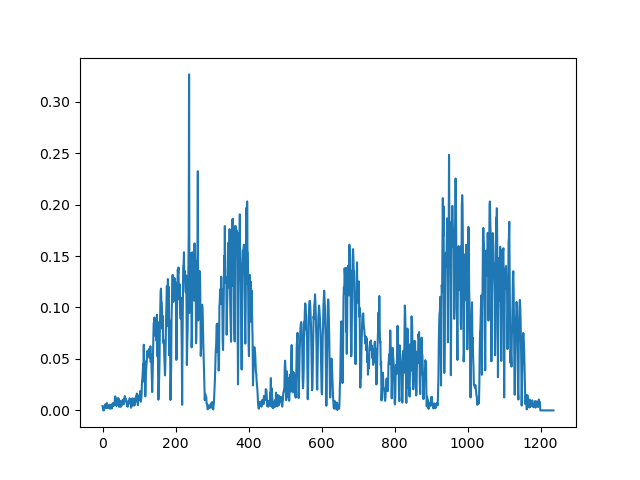

In [11]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# ax.plot(poses[:,:3,3])
# ax.plot(np.diff(poses[:,:3,3], axis = 0))
# poses_euls = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# ax.plot(poses_euls[:,:])

fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [28]:
# # idx = 2800 #2650 #2000 - 3000 is the running and swinging loop
# # idx = 2400 #very obvious translation distortion
# # idx = 2800 #VICET does much better than rigid ICET here!
# # idx = 2020 #static start
# # idx = 1800 #experiment 2 moving start
# idx = 2900
# skip = 1 #10 #how many lidar frames between clouds
# # (need to deal with how there are more LIDAR frames than ground truth poses)
# offset = 10 #10 #11  #works best for 05 dataset
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 961 #961 #test for website GIF
idx = 952 #1080 #950 #fast motion
# idx = 990 #slow distortion, very accurate solution
# idx = 530 #pan only -- HD map transformation doesn't work for this part of the dataset but 
# idx = 280 #from staic(ish) start
# idx = 990 #test for visualization (316 looks really good)
skip = 1 #30 #how many lidar frames between clouds
offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
# disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

# #COLOR SCAN1 POINTS BY ORDER IN CLOUD ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# # disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))
# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

# disp.append(Points(OG_in_hull, c = '#a65852', r = 5)) #red
# disp.append(Points(trans_in_hull, c = '#2c7c94', r = 5)) #blue
# disp.append(Points(pc1[::100,:], c = '#a65852', r = 3)) #red

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Generate exaggerated figure showing why ICP and NDT overestimate platform motion

In [18]:
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply exaggerated motion distortion to PC1 to generate figure
m_hat = np.array([0.5, -5., 0.0, 0.0, 0.,0.0])
pc1_distorted = dc.apply_motion_profile(pc1, m_hat, period_lidar=1)

# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc1_distorted, c = '#2c7c94', r = 3)) #blue
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run VICET (12-State ICET)

In [10]:
from linear_corrector import LC
# A0 = np.array([0., 0., 0., 0, 0, 0.0,
#                0., 0., 0, 0, 0., 0.])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 0.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 60, niter = 100, 
        draw = True, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 50, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 50, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = pc2_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 50, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)


# dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
#         fid = 50, niter = 50, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [ 0.08088714 -0.10536323  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


2023-08-22 17:08:45.921195: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0774 -0.1061  0.0068  0.0006  0.0005  0.0001] 
 [ 0.0086  0.0096 -0.0082 -0.0003  0.0003  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


2023-08-22 17:08:46.653882: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1692: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]
2023-08-22 17:08:46.782269: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7394190


A: 
 [ 0.074  -0.1065  0.0136  0.0012  0.0011  0.0001] 
 [ 0.0165  0.0183 -0.0168 -0.0006  0.0007  0.0015]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0713 -0.1049  0.0192  0.0018  0.0015  0.0002] 
 [ 0.0228  0.0237 -0.023  -0.0008  0.001   0.0022]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.068  -0.1066  0.0247  0.0023  0.002   0.0003] 
 [ 0.0298  0.034  -0.0293 -0.001   0.0013  0.0029]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0656 -0.1051  0.0303  0.0028  0.0024  0.0004] 
 [ 0.0349  0.0391 -0.0363 -0.0012  0.0016  0.0036]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0626 -0.1069  0.0355  0.0033  0.0028  0.0004] 
 [ 0.0406  0.0489 -0.0427 -0.0014  0.0019  0.0042]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0599 -0.1084  0.0407  0.0037  0.0033  0.0004] 
 [ 0.0457  0.0581 -0.049  -0.0016  0.0021  0.0048]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0581 -0.1075  0.0455  0.0042  0.0037  0.0005] 
 [ 0.049   0.0636 -0.0548 -0.0017  0.0023  0.0054]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.0315 -0.1561  0.1134  0.0104  0.0078 -0.0005] 
 [ 0.0154  0.2916 -0.1117  0.0065  0.0141  0.019 ]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [ 0.0318 -0.1563  0.1137  0.0103  0.0078 -0.0005] 
 [ 0.0137  0.2929 -0.1118  0.0067  0.0144  0.019 ]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [ 0.0325 -0.1562  0.114   0.0103  0.0077 -0.0005] 
 [ 0.0116  0.2936 -0.112   0.0069  0.0147  0.019 ]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [ 0.0333 -0.1566  0.1144  0.0103  0.0076 -0.0004] 
 [ 0.0096  0.2955 -0.1124  0.0071  0.015   0.0189]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [ 0.0338 -0.157   0.1144  0.0103  0.0075 -0.0004] 
 [ 0.0079  0.2969 -0.112   0.0073  0.0153  0.0189]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [ 0.0344 -0.1575  0.1144  0.0103  0.0074 -0.0004] 
 [ 0.0061  0.2984 -0.1115  0.0075  0.0157  0.0189]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [ 0.0349 -0.1579  0.1145  0.0103  0.0073 -0.0004] 
 [ 0.0043  0.3    -0.1113  0.0077  0.016   0.0189]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

AttributeError: 'LC' object has no attribute 'plt'

In [ ]:
initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
       draw = True, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print("\n VICET predicted standard deviations of error: \n", dc.pred_stds[:6].numpy())
print("\n ICET predicted standard deviations of error: \n",  it.pred_stds.numpy())

In [33]:
#test ICP registration on a single pair of frames
# icp_rigid_transform, _, _ = trimesh.registration.icp(pc1, pc2_in_pc1_frame) #scan to scan
icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
icp_trans = icp_rigid_transform[:3,3]
icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
print(icp_trans, icp_euls)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

alph = 0.05
# disp.append(Points(pc1, c = 'red', r =3, alpha = alph))
disp.append(Points(transformed_pc1, c = 'blue', r =3, alpha = 0.5))
# #COLOR new_cloud POINTS BY ORDER IN CLOUD ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# color = 255*np.linspace(0,1,len(transformed_pc1))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# disp.append(Points(transformed_pc1, c = cname, r = 3, alpha = 1))
# # # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
disp.append(Points(submap_in_pc1_frame, c = 'black', r = 2.5, alpha = alph))

plt.show(disp, "ICP Test")
ViewInteractiveWidget(plt.window)

[ 0.43737392  0.81482435 -0.80007756] [0.07826924 0.08029568 0.07766155]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## TODO: remove points from scan1 that lie far outside convex hull of HD Map (so we can calculate proper chamfer distance

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# tested = np.random.rand(1000,3)
# cloud  = np.random.rand(50,3)
# print(in_hull(tested,cloud))

# hull_inflation_scale = 1.05 #tight bounds around HD Map-- good for Quad With Dynamics
hull_inflation_scale = 1.125 #-- need wider bounds for Dynamic Spinning Trajectory 
hull = hull_inflation_scale*submap_in_pc1_frame[::100] #downsample and stretch
pc1_in_hull = pc1[np.where( in_hull(pc1, hull) )]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1, c ='red', r = 3))
disp.append(Points(pc1_in_hull, c = 'blue', r = 3))
# disp.append(Points(hull, c = 'k', alpha = 0.2))
disp.append(Points(submap_in_pc1_frame, c = 'k', r = 1, alpha = 0.2))
plt.show(disp, "Point Cloud 1 inside Convex Hull, Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [ ]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

subsample = 10 #downsample to every nth point

# #consider all LIDAR points (outliers cause chamfer distance to be not super useful)
# source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy()[::subsample,:])[None,:,:] #OG scan
# source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy()[::subsample,:])[None,:,:] #transformed scan

#only consdier LIDAR points within convex hull of HD Map + some buffer
hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:] #subsample
OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()

trans_in_hull = dc.cloud2_tensor.numpy()[::subsample,:] #subsample
trans_in_hull = trans_in_hull[np.where( in_hull(trans_in_hull, hull) )]
source_cloud_trans = torch.from_numpy(trans_in_hull)[None,:,:].float() 

target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]

# #downsample LIDAR clouds -- not sure why this doesn't work
# subsample_size = 10_000
# full_OG = dc.cloud2_tensor_OG.numpy()
# new_OG = full_OG[np.random.choice(full_OG.shape[0], subsample_size, replace=False), :]
# source_cloud_OG = torch.from_numpy(new_OG)[None,:,:] #OG scan
# full_trans = dc.cloud2_tensor.numpy()
# new_trans = full_trans[np.random.choice(full_trans.shape[0], subsample_size, replace=False), :]
# source_cloud_trans = torch.from_numpy(new_trans)[None,:,:] #transformed scan
# target_cloud = torch.from_numpy(submap_in_pc1_frame[::1,:3].astype(np.float32))[None,:,:]

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud, reverse = False)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud, reverse = False)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

# print("\n Normalized OG CD: \n", subsample*dist_forward_OG/len(dc.cloud2_tensor))
# print("\n Normalized transformed CD: \n", subsample*dist_forward_trans/len(dc.cloud2_tensor))

print("\n Normalized OG CD: \n", dist_forward_OG/len(source_cloud_OG))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(source_cloud_trans))

# Generate Scan-to-Submap Transform for 1000 frames of VICET/ ICET in 05

In [ ]:
st = time.time()
# runlen = 1000 #was this
# #05 dataset
# # start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start (was this)

runlen = 200
start_idx = 2700 #2800 #2700

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_std_hist = np.zeros([runlen, 12])
X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    
    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    try:
#         dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 100, 
#                 draw = False, mnp = 50, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)    
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
            fid = 55, niter = 100, draw = False, mnp = 50, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
        A_hist[idx,:] = dc.A
        VICET_pred_std_hist[idx,:] = dc.pred_stds

#         np.save("results/VICET/VICET_05_start_from_2700_v5", A_hist)
#         np.save("results/VICET/VICET_05_start_from_2020", A_hist)

    #     #run ICET ------------------------------------------------------------
        initial_guess = tf.constant([0.01*np.random.randn(),0.01*np.random.randn(),0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
        X_hist[idx,:] = it.X

#         np.save("results/ICET/ICET_05_start_from_2700_v5", X_hist)
#         np.save("results/ICET/ICET_05_start_from_2020", X_hist)
    
    except:
        pass

# Generate 100 frames of VICET odometry on 06 Dynamic Spinning 

In [ ]:
st = time.time()
runlen = 100

#06 dataset
# start_idx = 280
# start_idx = 550 
start_idx = 950

A_hist = np.zeros([runlen, 12]) #VICET
# X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     #odometry~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
#     skip = 1 #frame to frame
#     fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
#     fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
#     pc1 = np.load(fn1)
#     pc2 = np.load(fn2)
#     #transform everything to pc1 frame 
#     pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
#     pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    
#     #scan2 to initial keyframe (scan 1) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    skip = 1
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
#     transform everything to pc1 frame 
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    #seed with noisy initial transform to make things fair
#     A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
    
    #for experiment #2
    max_buffer = 2.5
    try:
        dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
            fid = 50, niter = 50, draw = False, mnp = 25, 
            RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)

        A_hist[idx,:] = dc.A    
    except:
        pass

#     np.save("results/VICET/VICET_06_odometry_start_at_frame_950", A_hist)    
    np.save("results/VICET/VICET_06_scan_to_keyframe_start_at_frame_950", A_hist)    
    
#     #run ICET ------------------------------------------------------------
#     initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
#     it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#     X_hist[idx,:] = it.X
    
# #     np.save("results/ICET/ICET_05_start_from_static_A_hist", X_hist)
    

# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [ ]:
st = time.time()
runlen = 200 #1000
# start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start
start_idx = 2700

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]


    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
   # Run ICP ---------------------------------------------------------------
    icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
    icp_trans = icp_rigid_transform[:3,3]
    icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
    
    # Calculate CD for raw, ICET, VICET --------------------------
    #full clouds
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()
    ICP_in_hull = transformed_pc1[::subsample,:] 
    ICP_in_hull = ICP_in_hull[np.where( in_hull(ICP_in_hull, hull) )]
    source_cloud_ICP = torch.from_numpy(ICP_in_hull)[None,:,:].float()
    
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())
    dist_forward_ICP = chamferDist(source_cloud_ICP, target_cloud)
    print("Chamfer Distance after ICP: \n:", dist_forward_ICP.detach().cpu().item())
    
    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    print("\n Normalized ICP CD: \n", dist_forward_ICP/len(transformed_pc1))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    ICP_CD_hist[idx] = dist_forward_ICP/len(transformed_pc1)

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [ ]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    
    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
#         dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 20, 
#                 draw = False, mnp = 25, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
#     it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
#            draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)

    # Run ICP ---------------------------------------------------------------
    icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
    icp_trans = icp_rigid_transform[:3,3]
    icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
#     X_hist_ICP[idx,:] = np.append(icp_trans, icp_euls) 
    
    
    # Calculate CD for raw, ICET, VICET --------------------------
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
#     hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    hull = 1.125*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    ICP_in_hull = transformed_pc1[::subsample,:] 
    ICP_in_hull = ICP_in_hull[np.where( in_hull(ICP_in_hull, hull) )]
    source_cloud_ICP = torch.from_numpy(ICP_in_hull)[None,:,:].float()

    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())
    dist_forward_ICP = chamferDist(source_cloud_ICP, target_cloud)
    print("Chamfer Distance after ICP: \n:", dist_forward_ICP.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    print("\n Normalized ICP CD: \n", dist_forward_ICP/len(transformed_pc1))    

    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)    
    ICP_CD_hist[idx] = dist_forward_ICP/len(transformed_pc1)

In [ ]:
# # #Quad with dynamics
np.savetxt("results/raw_CD_05_2700_v1.txt", raw_CD_hist)
np.savetxt("results/ICET_CD_05_2700_v1.txt", rigid_ICET_CD_hist)
np.savetxt("results/ICP_CD_05_2700_v1.txt", ICP_CD_hist)
np.savetxt("results/VICET_CD_05_2700_v1.txt", VICET_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_05_2400_v1.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_05_2400_v1.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_05_2400_v1.txt")

# # # ##dynamic spinning
# # np.savetxt("results/raw_CD_06_950_v5txt", raw_CD_hist)
# # np.savetxt("results/ICET_CD_06_950_v5.txt", rigid_ICET_CD_hist)
# # np.savetxt("results/VICET_CD_06_950_v5.txt", VICET_CD_hist)
# # np.savetxt("results/ICP_CD_06_950_v5.txt", ICP_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v5.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v5.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v5.txt")
# ICP_CD_hist = np.loadtxt("results/ICP_CD_06_950_v5.txt")


#throw out frames where each are worse than provided ICP baseline (it happens but very rarely)
bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
VICET_good_idx = np.where(VICET_CD_hist < raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
ICET_good_idx = np.where(rigid_ICET_CD_hist < raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
ICP_good_idx = np.where(ICP_CD_hist < raw_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "NDT")
ax.plot(VICET_CD_hist, label = "VICET")
ax.plot(ICP_CD_hist, label = "ICP")
ax.set_title("Chamfer Distance per Frame, 05: Dynamic Spinning")
# ax.set_title("Chamfer Distance per Frame, 06: Dynamic Spinning")
ax.set_xlabel("frame")
ax.set_ylabel("normalized chamfer distance (cm^2)")
ax.legend(loc = 'best')

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist[:-10])) #, np.sqrt(np.mean(raw_CD_hist)))
print("\n NDT:", np.mean(rigid_ICET_CD_hist))#, np.sqrt(np.mean(rigid_ICET_CD_hist[40:])))
print("\n VICET:",np.mean(VICET_CD_hist))#, np.sqrt(np.mean(VICET_CD_hist[40:])))
print("\n ICP:", np.mean(ICP_CD_hist), "\n")

print("\n ICET (filtered):", np.mean(rigid_ICET_CD_hist[ICET_good_idx]))
print("\n VICET (filtered):",np.mean(VICET_CD_hist[VICET_good_idx]))
print("\n ICP (filtered):",np.mean(ICP_CD_hist[ICP_good_idx]))

In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

# Draw provided "ground truth" trajectory on top of HD Map

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  # draw HD Map in red

#draw trajectory of platform according to <gt>
# disp.append(Points(gt[2225:3200,2:5], r=3))#, alpha = 0.2))
# disp.append(Points(gt[2241:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[2020:3000,2:5], r=3))#, alpha = 0.2)) #full loop starting from static pose

disp.append(Points(gt[2400,2:5][None,:], r=15, c= 'blue'))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(50):
#     rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
#     arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)